## 1, TimSort() Python Implementation:

In [24]:
# Took inspiration from Tim Peter's original explanation,
# https://github.com/python/cpython/blob/master/Objects/listsort.txt
# and the PyPy's implementation: 
# https://bitbucket.org/pypy/pypy/src/default/rpython/rlib/listsort.py?fileviewer=file-view-default

import random
import bisect


def reverse(lst, s, e):
    """Reverse the order of a list in place
    Input: s = starting index, e = ending index"""
    while s < e and s != e:
        lst[s], lst[e] = lst[e], lst[s]
        s += 1
        e -= 1


def make_temp_array(lst, s, e):
    """From the lst given, make a copy from index s to index e"""
    array = []
    while s <= e:
        array.append(lst[s])
        s += 1
    return array


def merge_compute_minrun(n):
    """Returns the minimum length of a run from 23 - 64 so that
    the len(array)/minrun is less than or equal to a power of 2."""
    r = 0
    while n >= 64:
        r |= n & 1
        n >>= 1
    return n + r


def count_run(lst, s_run):
    """Count the length of one run, returns starting/ending indices,
    a boolean value to present increasing/decreasing run,
    and the length of the run"""
    increasing = True

    # If count_run started at the final position of the array
    if s_run == len(lst) - 1:
        return [s_run, s_run, increasing, 1]
    else:
        e_run = s_run
        # Decreasing run (strictly decreasing):
        if lst[s_run] > lst[s_run + 1]:
            while lst[e_run] > lst[e_run + 1]:
                e_run += 1
                if e_run == len(lst) - 1:
                    break
            increasing = False
            return [s_run, e_run, increasing, e_run - s_run + 1]

        # Increasing run (non-decreasing):
        else:
            while lst[e_run] <= lst[e_run + 1]:
                e_run += 1
                if e_run == len(lst) - 1:
                    break
            return [s_run, e_run, increasing, e_run - s_run + 1]


def bin_sort(lst, s, e, extend):
    """Binary insertion sort, assumed that lst[s:e + 1] is sorted.
    Extend the run by the number indicated by 'extend'"""

    for i in range(1, extend + 1):
        pos = 0
        start = s
        end = e + i
        
        # Value to be inserted
        value = lst[end]
        
        # If the value is already bigger than the last element from start -> end:
        # Don't do the following steps
        if value >= lst[end - 1]:
            continue
        
        # While-loop does the binary search
        while start <= end:
            if start == end:
                if lst[start] > value:
                    pos = start
                    break
                else:
                    pos = start + 1
                    break
            mid = (start + end) // 2
            if value >= lst[mid]:
                start = mid + 1
            else:
                end = mid - 1

        if start > end:
            pos = start
        
        # 'Push' the elements to the right by 1 element
        # Copy the value back the right position.
        for x in range(e + i, pos, - 1):
            lst[x] = lst[x - 1]
        lst[pos] = value


def gallop(lst, val, low, high, ltr):
    """Find the index of val in the slice[low:high]"""
    
    if ltr == True:
        # Used for merging from left to right
        # The index found will be so that every element prior
        # to that index is strictly smaller than val
        pos = bisect.bisect_left(lst, val, low, high)
        return pos

    else:
        # Used for merging from right to left
        # The index found will be so that every element from 
        # that index onwards is strictly larger than val
        pos = bisect.bisect_right(lst, val, low, high)
        return pos


def merge(lst, stack, run_num):
    """Merge the two runs and update the remaining runs in the stack
    Only consequent runs are merged, one lower, one upper."""

    # Make references to the to-be-merged runs
    run_a = stack[run_num]
    run_b = stack[run_num + 1]

    # Make a reference to where the new combined run would be.
    new_run = [run_a[0], run_b[1], True, run_b[1] - run_a[0] + 1]

    # Put this new reference in the correct position in the stack
    stack[run_num] = new_run

    # Delete the upper run of the two runs from the stack
    del stack[run_num + 1]

    # If the length of run_a is smaller than or equal to length of run_b
    if run_a[3] <= run_b[3]:
        merge_low(lst, run_a, run_b, 7)
        
    # If the length of run_a is bigger than length of run_b
    else:
        merge_high(lst, run_a, run_b, 7)


def merge_low(lst, a, b, min_gallop):
    """Merges the two runs quasi in-place if a is the smaller run
    - a and b are lists that store data of runs
    - min_gallop: threshold needed to switch to galloping mode
    - galloping mode: uses gallop() to 'skip' elements instead of linear merge"""
    
    # Make a copy of the run a, the smaller run
    temp_array = make_temp_array(lst, a[0], a[1])
    # The first index of the merging area
    k = a[0]
    # Counter for the temp array of a
    i = 0
    # Counter for b, starts at the beginning
    j = b[0]

    gallop_thresh = min_gallop
    while True:
        a_count = 0  # number of times a win in a row
        b_count = 0  # number of times b win in a row

        # Linear merge mode, taking note of how many times a and b wins in a row.
        # If a_count or b_count > threshold, switch to gallop
        while i <= len(temp_array) - 1 and j <= b[1]:
            
            # if elem in a is smaller, a wins
            if temp_array[i] <= lst[j]:
                lst[k] = temp_array[i]
                k += 1
                i += 1

                a_count += 1
                b_count = 0

                # If a runs out during linear merge
                # Copy the rest of b
                if i > len(temp_array) - 1:
                    while j <= b[1]:
                        lst[k] = lst[j]
                        k += 1
                        j += 1
                    return
                
                # threshold reached, switch to gallop
                if a_count >= gallop_thresh:
                    break
            
            # if elem in b is smaller, b wins
            else:
                lst[k] = lst[j]
                k += 1
                j += 1

                a_count = 0
                b_count += 1

                # If b runs out during linear merge
                # copy the rest of a
                if j > b[1]:
                    while i <= len(temp_array) - 1:
                        lst[k] = temp_array[i]
                        k += 1
                        i += 1
                    return
                
                # threshold reached, switch to gallop
                if b_count >= gallop_thresh:
                    break

        # If one run is winning consistently, switch to galloping mode.
        # i, j, and k are incremented accordingly
        while True:
            # Look for the position of b[j] in a
            # bisect_left() -> a_adv = index in the slice [i: len(temp_array)]
            # so that every elem before temp_array[a_adv] is strictly smaller than lst[j]
            a_adv = gallop(temp_array, lst[j], i, len(temp_array), True)
            
            # Copy the elements prior to a_adv to the merge area, increment k
            for x in range(i, a_adv):
                lst[k] = temp_array[x]
                k += 1

            # Update the a_count to check successfulness of galloping
            a_count = a_adv - i

            # Advance i to a_adv
            i = a_adv

            # If run a runs out
            if i > len(temp_array) - 1:
                # Copy all of b over, if there is any left
                while j <= b[1]:
                    lst[k] = lst[j]
                    k += 1
                    j += 1
                return

            # Copy b[j] over
            lst[k] = lst[j]
            k += 1
            j += 1

            # If b runs out
            if j > b[1]:
                # Copy all of a over, if there is any left
                while i < len(temp_array):
                    lst[k] = temp_array[i]
                    k += 1
                    i += 1
                return

            # ------------------------------------------------------
            
            # Look for the position of a[i] in b
            # b_adv is analogous to a_adv
            b_adv = gallop(lst, temp_array[i], j, b[1] + 1, True)
            for y in range(j, b_adv):
                lst[k] = lst[y]
                k += 1

            # Update the counters and check the conditions
            b_count = b_adv - j
            j = b_adv

            # If b runs out
            if j > b[1]:
                # copy the rest of a over
                while i <= len(temp_array) - 1:
                    lst[k] = temp_array[i]
                    k += 1
                    i += 1
                return
            
            # copy a[i] over to the merge area
            lst[k] = temp_array[i]
            i += 1
            k += 1

            # If a runs out
            if i > len(temp_array) - 1:
                # copy the rest of b over
                while j <= b[1]:
                    lst[k] = lst[j]
                    k += 1
                    j += 1
                return
            
            # if galloping proves to be unsuccessful, return to linear
            if a_count < gallop_thresh and b_count < gallop_thresh:
                break
        
        # punishment for leaving galloping
        # makes it harder to enter galloping next time
        gallop_thresh += 1


def merge_high(lst, a, b, min_gallop):
    """Merges the two runs quasi in-place if b is the smaller run
    - Analogous to merge_low, but starts from the end
    - a and b are lists that store data of runs
    - min_gallop: threshold needed to switch to galloping mode
    - galloping mode: uses gallop() to 'skip' elements instead of linear merge"""
    
    # Make a copy of b, the smaller run
    temp_array = make_temp_array(lst, b[0], b[1])
    
    # Counter for the merge area, starts at the last index of array b
    k = b[1]
    # Counter for the temp array
    
    i = len(temp_array) - 1  # Lower bound is 0
    
    # Counter for a, starts at the end this time
    j = a[1]

    gallop_thresh = min_gallop
    while True:
        a_count = 0  # number of times a win in a row
        b_count = 0  # number of times b win in a row

        # Linear merge, taking note of how many times a and b wins in a row.
        # If a_count or b_count > threshold, switch to gallop
        while i >= 0 and j >= a[0]:
            if temp_array[i] > lst[j]:
                lst[k] = temp_array[i]
                k -= 1
                i -= 1

                a_count = 0
                b_count += 1

                # If b runs out during linear merge
                if i < 0:
                    while j >= a[0]:
                        lst[k] = lst[j]
                        k -= 1
                        j -= 1
                    return

                if b_count >= gallop_thresh:
                    break

            else:
                lst[k] = lst[j]
                k -= 1
                j -= 1

                a_count += 1
                b_count = 0

                # If a runs out during linear merge
                if j < a[0]:
                    while i >= 0:
                        lst[k] = temp_array[i]
                        k -= 1
                        i -= 1
                    return

                if a_count >= gallop_thresh:
                    break
        
        # i, j, k are DECREMENTED in this case
        while True:
            # Look for the position of b[i] in a[0, j + 1]
            # ltr = False -> uses bisect_right()
            a_adv = gallop(lst, temp_array[i], a[0], j + 1, False)

            # Copy the elements from a_adv -> j to merge area
            # Go backwards to the index a_adv
            for x in range(j, a_adv - 1, -1):
                lst[k] = lst[x]
                k -= 1

            # # Update the a_count to check successfulness of galloping
            a_count = j - a_adv + 1

            # Decrement index j
            j = a_adv - 1

            # If run a runs out:
            if j < a[0]:
                while i >= 0:
                    lst[k] = temp_array[i]
                    k -= 1
                    i -= 1
                return

            # Copy the b[i] into the merge area
            lst[k] = temp_array[i]
            k -= 1
            i -= 1

            # If a runs out:
            if i < 0:
                while j >= a[0]:
                    lst[k] = lst[j]
                    k -= 1
                    j -= 1
                return

            # -------------------------------------------------
            
            # Look for the position of A[j] in B:
            b_adv = gallop(temp_array, lst[j], 0, i + 1, False)
            for y in range(i, b_adv - 1, -1):
                lst[k] = temp_array[y]
                k -= 1

            b_count = i - b_adv + 1
            i = b_adv - 1

            # If b runs out:
            if i < 0:
                while j >= a[0]:
                    lst[k] = lst[j]
                    k -= 1
                    j -= 1
                return

            # Copy the a[j] back to the merge area
            lst[k] = lst[j]
            k -= 1
            j -= 1

            # If a runs out:
            if j < a[0]:
                while i >= 0:
                    lst[k] = temp_array[i]
                    k -= 1
                    i -= 1
                return
            
            # if galloping proves to be unsuccessful, return to linear
            if a_count < gallop_thresh and b_count < gallop_thresh:
                break
        
        # punishment for leaving galloping
        gallop_thresh += 1


def merge_collapse(lst, stack):
    """The last three runs in the stack is A, B, C.
    Maintains invariants so that their lengths: A > B + C, B > C
    Translated to stack positions:
       stack[-3] > stack[-2] + stack[-1]
       stack[-2] > stack[-1]
    Takes a stack that holds many lists of type [s, e, bool, length]"""
    
    # This loops keeps running until stack has one element
    # or the invariant holds.
    while len(stack) > 1:
        if len(stack) >= 3 and stack[-3][3] <= stack[-2][3] + stack[-1][3]:
            if stack[-3][3] < stack[-1][3]:
                # merge -3 and -2, merge at -3
                merge(lst, stack, -3)
            else:
                # merge -2 and -1, merge at -2
                merge(lst, stack, -2)
        elif stack[-2][3] <= stack[-1][3]:
            # merge -2 and -1, merge at -2
            merge(lst, stack, -2)
        else:
            break


def merge_force_collapse(lst, stack):
    """When the invariant holds and there are > 1 run
    in the stack, this function finishes the merging"""
    while len(stack) > 1:
        # Only merges at -2, because when the invariant holds,
        # merging would be balanced
        merge(lst, stack, -2)


def timsort(lst):
    """The main function"""
    
    # Starting index
    s = 0
    
    # Ending index
    e = len(lst) - 1
    
    # The stack
    stack = []
    
    # Compute min_run using size of lst
    min_run = merge_compute_minrun(len(lst))
    
    while s <= e:

        # Find a run, return [start, end, bool, length]
        run = count_run(lst, s)

        # If decreasing, reverse
        if run[2] == False:
            reverse(lst, run[0], run[1])
            # Change bool to True
            run[2] = True
        
        # If length of the run is less than min_run    
        if run[3] < min_run:
            # The number of indices by which we want to extend the run
            # either by the distance to the end of the lst
            # or by the length difference between run and minrun
            extend = min(min_run - run[3], e - run[1])
            
            # Extend the run using binary insertion sort
            bin_sort(lst, run[0], run[1], extend)
            
            # Update last index of the run
            run[1] = run[1] + extend
            
            # Update the run length
            run[3] = run[3] + extend
        
        # Push the run into the stack
        stack.append(run)
        
        # Start merging to maintain the invariant
        merge_collapse(lst, stack)
        
        # Update starting position to find the next run
        # If run[1] == end of the lst, s > e, loop exits
        s = run[1] + 1
    
    # Some runs might be left in the stack, complete the merging.
    merge_force_collapse(lst, stack)
    
    # Return the lst, ta-da.
    return lst

## 2, Test cases and Test functions:

In [23]:
# TEST CASES #

# Emtpy array
lst1 = []
# Single element
lst2 = [1]
# Two elements
lst3 = [1, 2]
# Alternating elements
lst4 = [-1,2] * 1000
# Ordered elements with pos and neg values
lst5 = [i for i in range(-1000, 1000)]
# Inversely ordered elements with pos and neg values
lst6 = [i for i in range(1000, -1000, -1)]
# Even number of random ints
lst7 = [random.randint(-10000, 10000) for i in range(1000)]
# Odd number of random ints
lst8 = [random.randint(-10000, 10000) for i in range(999)]
# More alternating elements
lst9 = [-1,2,-3,4,5]*1000
# Floats
lst10 = [(i + 0.2) for i in range(10000)]
# Ordered even numbers
lst11 = [i for i in range(1000, 2)]
# Full of zeros
lst12 = [0 for i in range(1000)]
# Inversely ordered odd numbers
lst13 = [i for i in range(9999, -1, -2)]

test_cases = [lst1, lst2, lst3, lst4, lst5, lst6, lst7, 
              lst8, lst9, lst10, lst11, lst12, lst13]

test_cases_alt = [lst1, lst2, lst3, lst4, lst5, lst6, lst7, 
              lst8, lst9, lst10, lst11, lst12, lst13]

def test_sort():
    """Test accuracy of algorithm"""
    for lst in test_cases:
        # Make a copy of the case
        sortable = lst.copy()
        
        # Make another copy of the case
        sortable_copy = lst.copy()
        sorted_copy = timsort(sortable_copy)

        assert sorted_copy is sortable_copy
        assert sorted_copy == sorted(sortable)

    return "No error"


def test_sort_alt():
    for lst in test_cases_alt:
        # Create a copy of the list
        copy = lst.copy()
        
        timsort(lst)
        # Compare each element to the next element
        for i in range(len(lst) - 1):
            assert lst[i] <= lst[i + 1]

        # Assure that the lengths are the same
        assert len(copy) == len(lst)

        # Sort the copy using default
        copy.sort()

        # Every element in lst is in copy
        for i in range(len(lst)):
            assert copy[i] == lst[i]

    return 'No error'

test_sort_alt(), test_sort()

('No error', 'No error')

## 3, Discussion of TimSort:

At its core, TimSort is a quest to make merging as efficient as possible by answering three basic questions:

1) Are there cases in which we can do something better than simple merging?

2) How to perform fewer merges?

3) How do we make merges faster?

We'll explore the answer to these questions as we go through how TimSort optimizes the sorting process so that it has the same Big-O complexity as traditional merge sort, which is O(nlogn)(Auger, Nicaud & Pivoteau, 2015), but with a much better constant factor, and in the best case, even performs at O(n).

Before any merging is done, TimSort decides what gets to be merge by going through the list and saving non-decreasing or strictly decreasing arrays of numbers, called "runs." Decreasing runs are eventually reversed so that all runs found are non-decreasing or strictly increasing. Runs are pushed to a stack so that a merge procedure can be executed. These runs are guaranteed to be of a minimum size called "minrun," usually between 32 - 64, for two reasons. First, it reduces the number of necessary merges. Second, forcing a run to be of a certain size uses Binary Insertion Sort, which is an Insertion Sort, an algorithm that works well with arrays of small sizes, but uses Binary Search to shorten search time from O(n) to O(logn). Essentially, TimSort is leveraging the simplicity and efficiency of Binary Insertion Sort to take care of chunks in the original list, before going through the merging process. In the best case, when the array is sorted, the entire list will be the run, and the comparisons needed to make this conclusion is O(n) (with my implementation). Compared to traditional merge sort, even if the list is sorted, the runtime still takes O(nlogn) because it divides indiscriminately and all the time. Already, we see that TimSort is an improvement over the traditional algorithm.

As for the merging process, merging is done concurrently with the identification of runs. Two main factors dictate the merging process. **When** merging happens is decided by the following invariant of the three top-most entries in the stack being A, B, and C, with C at the top:

- len(A) > len(B) + len(C)
- len(B) > len(C)

If either of these invariants is false, B will be merged with the smaller of A and C, and the algorithm rechecks the validity of the invariants after the merge and keeps merging until the invariant holds, or there is only one run left in the stack. The main idea of this invariant is to balance run lengths as closely as possible while keeping the number of runs we have to remember in the stack low. The invariant thus optimizes both merging efficiency and memory usage.

**How** merging happens is decided by the size of each run and the potential existence of a natural order between the two runs. Merging is done quasi in-place; the run with the shorter length is copied to a new temporary array to be used during the merging process. Traditional mergesort that is not in-place requires two temporary arrays, one for each array being merged, and a common merge area. In TimSort, merging can be done with only one temporary array for storage, which cuts memory usage by at most half of the total length of the two runs. Afterward, TimSort initially uses linear merging, which takes O(n) comparisons, similar to usual merge sort. Eventually, if TimSort observes that linear merging is allowing entries from one run to enter the merging area consecutively, it will switch to "galloping mode." This streak suggests that there might be an order between the two runs and it might be worth it to perform a binary search, O(logn), to "gallop" over multiple entries. For example, for two sorted runs A and B, TimSort would find the position of A[0] in B. Any element in B before this position can be skipped because we know for sure that it is less than A[0], and we can just move that entire chunk to the merge area. The same process can be done with B[0] and A. The problem with galloping is that it might not always pay off, so doing it all the time might even be more costly. According to Tim Peters, having such an order in cases like random data is extremely unlikely, so when galloping is not paying off, the algorithm moves back to linear merging. To decide whether galloping is paying off or not, a threshold of 7 is passed to the algorithm. If 7 or more elements from a run are consecutively entering the merge area, TimSort switches to galloping. While galloping, it still keeps track of this streak, and if the number of items skipped ever goes below the threshold, TimSort exits galloping and increases the threshold by 1 to make it harder to reenter galloping mode, suggesting that there might not exist such an order in the data.

All of these optimizations suggest that TimSort, with its O(nlogn) complexity, has a better constant factor than traditional mergesort and even a better best-case complexity. Thanks its adaptability, TimSort can be used for almost all cases: short arrays, long arrays, random arrays, ... It works especially well when the data has implicit order. These reasons could justify why it is the general purpose sorting algorithm of choice for Python, Java, and Android.

## 4, Average runtime comparison with mergesort:

In [13]:
# Code for traditional merge sort, implemented using pseudo code from Cormen et al.
def mergesort(A, p, r):
    if p < r:
        q = (p + r)//2
        mergesort(A, p, q)
        mergesort(A, q + 1, r)
        merge_helper(A, p, q, r)


def merge_helper(A, p, q, r):
    n1 = q - p + 1
    n2 = r - q
    L = [None]*(n1 + 1)
    R = [None]*(n2 + 1)
    for i in range(n1):
        L[i] = A[p + i]
    for j in range(n2):
        R[j] = A[q + 1 + j]
    L[n1] = float('inf')
    R[n2] = float('inf')
    i = 0
    j = 0
    for k in range(p, r + 1):
        if L[i] <= R[j]:
            A[k] = L[i]
            i += 1
        else:
            A[k] = R[j]
            j += 1

### 4.1 With random data

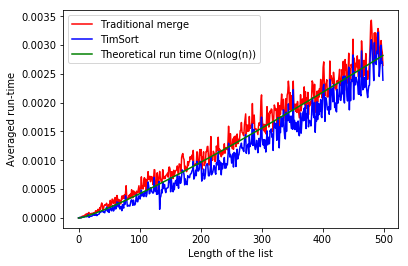

In [19]:
import matplotlib.pyplot as plt
import time
import math


def graph_runtimes(length_lst, repeats):
    merge_avg = []
    timsort_avg = []
    theory_time = [0]
    
    # Providing data for theoretical run times
    # Adjusted so it matches the curve created by the algorithms
    for i in range(1, length_lst):
        theory_time.append(i*math.log(i)/1100000)
    
    # Nested for loop: for every length N, run algorithms 'repeats' times
    # Average the results, append into lists
    for i in range(length_lst):
        merge_lst = []
        timsort_lst = []

        for x in range(repeats):
            mylist = random.sample(range(i), i)
            copy = mylist.copy()

            start_time = time.time()
            mergesort(mylist, 0, len(mylist) - 1)
            finish_time = time.time() - start_time
            merge_lst.append(finish_time)

            start_time = time.time()
            timsort(copy)
            finish_time = time.time() - start_time
            timsort_lst.append(finish_time)

        avg_merge = sum(merge_lst)/len(merge_lst)
        avg_timsort = sum(timsort_lst)/len(timsort_lst)

        merge_avg.append(avg_merge)
        timsort_avg.append(avg_timsort)
    
    # Plot individual graphs for each curve
    plt.plot(merge_avg, color='red', label = 'Traditional merge')
    plt.plot(timsort_avg, color='blue', label = 'TimSort')
    plt.plot(theory_time, color='green', label = 'Theoretical run time O(nlog(n))')
    plt.xlabel("Length of the list")
    plt.ylabel("Averaged run-time")
    plt.legend()
    plt.show()


graph_runtimes(500, 200)
# Note to Prof. Ribeiro: might take a bit to run

### 4.2 With worst case of mergesort - maximizing comparisons

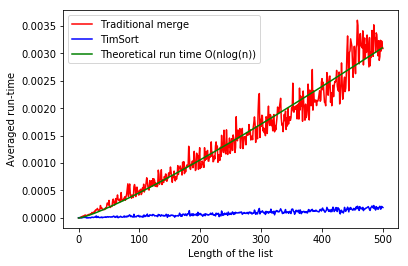

In [20]:
def worstCases(n):
    """Generates the worst case scenario for merge sort
    with maxiimum comparisons possible for every size N"""
    
    # Holds base cases of N = 1, N = 2
    lst = [[], [1], [2,1]]
    
    # Builds worst cases from the bottom up
    for i in range(3, n + 1):
        left = lst[i//2]
        right = lst[i - i//2]
        left = [x*2 for x in left]
        right = [y*2 - 1 for y in right]
        entry = left + right
        lst.append(entry)
    return lst


def graph_runtimes_worst(length_lst, repeats):
    merge_avg = []
    timsort_avg = []
    theory_time = [0]
    worst_cases = worstCases(length_lst)

    for i in range(1, length_lst):
        theory_time.append(i*math.log(i)/1000000)

    for i in worst_cases:
        merge_lst = []
        timsort_lst = []

        for x in range(repeats):
            mylist = i
            copy = mylist.copy()

            start_time = time.time()
            mergesort(mylist, 0, len(mylist) - 1)
            finish_time = time.time() - start_time
            merge_lst.append(finish_time)

            start_time = time.time()
            timsort(copy)
            finish_time = time.time() - start_time
            timsort_lst.append(finish_time)

        avg_merge = sum(merge_lst)/len(merge_lst)
        avg_timsort = sum(timsort_lst)/len(timsort_lst)

        merge_avg.append(avg_merge)
        timsort_avg.append(avg_timsort)

    plt.plot(merge_avg, color='red', label = 'Traditional merge')
    plt.plot(timsort_avg, color='blue', label = 'TimSort')
    plt.plot(theory_time, color='green', label = 'Theoretical run time O(nlog(n))')
    plt.xlabel("Length of the list")
    plt.ylabel("Averaged run-time")
    plt.legend()
    plt.show()

graph_runtimes_worst(500, 300)

### 4.3 With sorted data - best case TimSort

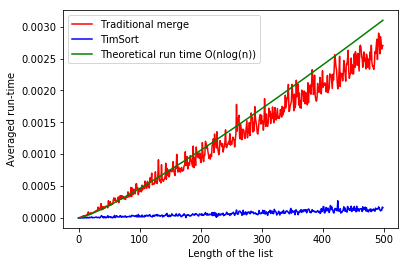

In [22]:
# Simulation with traditional mergesort and timsort: with sorted data
# i.e best case TimSort
def graph_runtimes_best(length_lst, repeats):
    """Identical to graph_runtimes, but with ordered data"""
    merge_avg = []
    timsort_avg = []
    theory_time = [0]
    
    for i in range(1, length_lst):
        theory_time.append(i*math.log(i)/1000000)    

    for i in range(length_lst):
        merge_lst = []
        timsort_lst = []

        for x in range(repeats):
            
            # Here is the only change
            mylist = [x for x in range(i)]
            copy = mylist.copy()

            start_time = time.time()
            mergesort(mylist, 0, len(mylist) - 1)
            finish_time = time.time() - start_time
            merge_lst.append(finish_time)

            start_time = time.time()
            timsort(copy)
            finish_time = time.time() - start_time
            timsort_lst.append(finish_time)

        avg_merge = sum(merge_lst)/len(merge_lst)
        avg_timsort = sum(timsort_lst)/len(timsort_lst)

        merge_avg.append(avg_merge)
        timsort_avg.append(avg_timsort)

    plt.plot(merge_avg, color='red', label = 'Traditional merge')
    plt.plot(timsort_avg, color='blue', label = 'TimSort')
    plt.plot(theory_time, color='green', label = 'Theoretical run time O(nlog(n))')
    plt.xlabel("Length of the list")
    plt.ylabel("Averaged run-time")
    plt.legend()
    plt.show()

graph_runtimes_best(500, 200)

The first graph shows that in the case where elements are completely random, TimSort performs better than traditional mergesort, while both algorithms follow the nlogn theoretical curve. This graph supports the claim in the discussion above that TimSort has a better constant factor than traditional merge. The second graph shows how TimSort do much better than usual merge in the worst case of usual merge. The third graph illustrates TimSort's superior performance in its best case when the array is sorted.

I predict that on certain types of data where there is implicit order, TimSort would also perform better than normal mergesort because it does not divide the array indiscriminately. Testing this would require a lot of real world data, which cannot be done within the scope of this project. Additionally, with a different, more efficient implementation of TimSort, I predict that TimSort will perform even better.

## Appendix:

### HC's

- #algorithms: I wrote working code for a complex algorithm. The code was structured into understandable chunks, and there is an abundance of comments/docstrings to guide the reader through the code. I also wrote auxiliary functions to test the accuracy of my code using many test cases.
- #breakitdown: The TimSort implementation consisted of many different interconnecting parts. Instead of putting it all in one chunk, I broke the algorithm down into many different functions and coded them accordingly.
- #dataviz: I generated graphs that contain averaged runtime results to compare the performance of TimSort and traditional mergesort in three cases: randomized data, sorted data, and worst case of mergesort. I used the graphs to support my discussion on TimSort as well.
- #optimization: As explained, TimSort leverages a lot of techniques here and there to optimize performance. I accurately defined what they are and why they made sense in this case, in addition to correctly implementing them in code and showing real improvements to traditional mergesort with graphs.
- #organization: I effectively structured this project into 3 main parts. First is the Python implementation and testing portions, which sets the stage for the discussion that follows. Finally, figures are presented as supporting data to my conclusion in the discussion.

### LO's

- #sort: I effectively implemented TimSort, which is essentially a combination of mergesort and insertion sort, but with a lot more modifications for the sake of optimization.
- #optimalalgorithm: I discussed and explained thoroughly the ways through which TimSort accomplishes the same thing as mergesort, but with a better average runtime (supported by graphs). These ways included: the inclusion of binary insertion sort, effective memory management using invariants, merging quasi in-place, and galloping.
- #complexity: I opened my discussion with the overall complexity of TimSort, and throughout my discussion I frequently and accurately used time complexities to explain why some aspects of TimSort were better than that of usual merge sort.

## Bibliography:
- Auger, N., Nicaud, C., & Pivoteau, C. (2015). Merge Strategies: From Merge Sort to TimSort. Retrieved December 20, 2018, from https://hal-upec-upem.archives-ouvertes.fr/hal-01212839v2/document
- Cormen, T. H., Leiserson, C. E., Rivest, R. L., & Stein, C. (2009). Introduction to Algorithms (3rd ed.)
- Listsort.py. (n.d.). Retrieved December 20, 2018, from https://bitbucket.org/pypy/pypy/src/default/rpython/rlib/listsort.py?fileviewer=file-view-default
- Peters, T. (n.d.). GitHub. Retrieved December 20, 2018, from https://github.com/python/cpython/blob/master/Objects/listsort.txt